<a href="https://colab.research.google.com/github/u2126450/CTI-Dissertation-Notebooks/blob/main/DeepLearningCTI_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Dataset shape: (92212, 59)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1614/1614 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8982 - loss: 0.2572 - val_accuracy: 0.9565 - val_loss: 0.1135
Epoch 2/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9599 - loss: 0.1180 - val_accuracy: 0.9733 - val_loss: 0.0778
Epoch 3/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9661 - loss: 0.0958 - val_accuracy: 0.9716 - val_loss: 0.0689
Epoch 4/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9720 - loss: 0.0812 - val_accuracy: 0.9744 - val_loss: 0.0653
Epoch 5/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9749 - loss: 0.0726 - val_accuracy: 0.9823 - val_loss: 0.0553
Epoch 6/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9763 - loss: 0.0679 - val_accuracy: 0.9843 - val_loss: 0.0515
Epoch 7/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9774 - loss: 0.0641 - val_accuracy: 0.9845 - val_loss: 0.0458
Epoch 8/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9777 - loss: 0.0637 - val_accurac

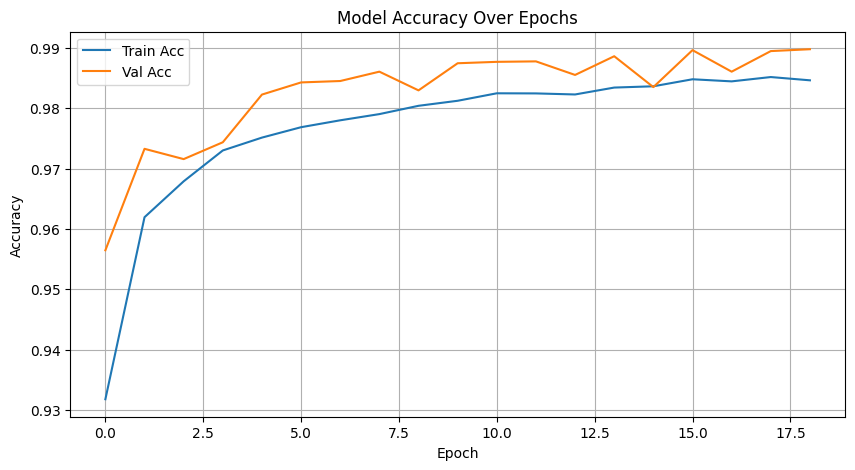


[CTI] Detected 11527 malicious flows using Deep Learning.


In [ ]:
# CTI Simulation: Deep Learning for Threat Detection using CTU-13 Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
drive.mount('/content/drive')

# -----------------------------
# 1. Load and Combine Data
# -----------------------------
attack_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/CTI Simulation/CTU13_Attack_Traffic.csv")
normal_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/CTI Simulation/CTU13_Normal_Traffic.csv")

attack_df["Label"] = "Malicious"
normal_df["Label"] = "Benign"

df = pd.concat([attack_df, normal_df], ignore_index=True)
print("Dataset shape:", df.shape)

# -----------------------------
# 2. Preprocessing
# -----------------------------
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)

# Encode categorical features
label_encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    if col != "Label":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Encode target
df["Label"] = df["Label"].map({"Benign": 0, "Malicious": 1})
df.fillna(0, inplace=True)

# -----------------------------
# 3. Feature Scaling
# -----------------------------
X = df.drop("Label", axis=1)
y = df["Label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# -----------------------------
# 4. Build Deep Learning Model
# -----------------------------
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# 5. Train the Model
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# -----------------------------
# 6. Evaluate Model
# -----------------------------
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int").flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# -----------------------------
# 7. Visualize Training
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# 8. Threat Intelligence Output
# -----------------------------
# Suspicious flows detected
malicious_indices = np.where((y_test.values == 1) & (y_pred == 1))[0]
suspicious_flows = pd.DataFrame(X_test[malicious_indices], columns=X.columns)

print(f"\n[CTI] Detected {len(suspicious_flows)} malicious flows using Deep Learning.")
